# AT&T Spam Detection

- Objective: Build a Deep Learning algorithm in order to automatize and reduce spam detection.

## Imports and Exploration
- Data and Libraries
- Basic Data Exploration

In [1]:
# data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# text preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

# DL
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

# other
import random
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import data
path = "spam.csv"
df = pd.read_csv(path, encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop unused columns
df = df[["v1", "v2"]]

# rename columns
df = df.rename(columns={"v1":"label",
                        "v2":"text"})

df.columns

Index(['label', 'text'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
# percentage of missing values
display(df.isna().sum() / len(df))

label    0.0
text     0.0
dtype: float64

##### Insight

13.41% of mails are spam, while 86.59% are ham.



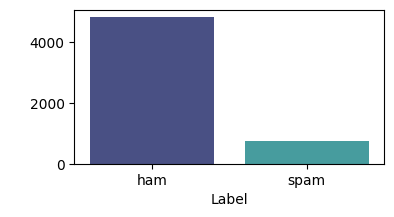

In [7]:
# percent spam
percent_spam = (df["label"].value_counts(1).round(4)[1])*100
percent_ham = 100 - percent_spam
print(f"{percent_spam}% of mails are spam, while {percent_ham}% are ham.\n")
plt.figure(figsize=(4,2))
sns.countplot(data=df, x="label",
              palette="mako")
plt.xlabel("Label")
plt.ylabel(" ")
plt.show()

In [8]:
# change labels to numbers
df["label"].replace("ham", 0, inplace=True)
df["label"].replace("spam", 1, inplace=True)
np.unique(df["label"])

array([0, 1])

In [9]:
# look at text samples
df["text"][0:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: text, dtype: object

## Preprocessing
Necessary preprocessing steps:
- Remove Special Characters
- Lowercase
- Remove Stopwords
- Lemmatization
- Remove blank Spaces
- Train-test split
- Encoding
- Padding
- Slicing
- Shuffling in Batches

### Special Characters

In [10]:
# remove non-letters, replace with withe spaces, which will be removed later
df["text"] = df["text"].str.replace(r"[^a-z]", " ", regex=True,
                                    flags=re.IGNORECASE)
df.head()

,label,text
0,0,Go until jurong point crazy Available only ...
1,0,Ok lar Joking wif u oni
2,1,Free entry in a wkly comp to win FA Cup fina...
3,0,U dun say so early hor U c already then say
4,0,Nah I don t think he goes to usf he lives aro...


In [11]:
# are there any punctuation left on dataset?
punct = string.punctuation

for i in df["text"]:
    temp_list = i.split()
    for char in punct:
      if char in temp_list:
        print(True)

### Lowercase

In [12]:
df["text"] = df["text"].apply(str.lower)
df.head()

,label,text
0,0,go until jurong point crazy available only ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives aro...


### Stopwords

In [13]:
# create list of english stopwords
stopwords_list = stopwords.words('english')

# remove negative words, as they change meaning in sentence
stopwords_list.remove("no")
stopwords_list.remove("not")
stopwords_list.remove("nor")

In [14]:
# divide strings of text
# keep token if it not in "stopwords_list", hence removing stopwords

filtered_tokens = []
for i in df["text"].str.split():
  filtered_tokens.append([token for token in i if token not in stopwords_list])

# show sample
filtered_tokens[0:5]

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni'],
 ['free',
  'entry',
  'wkly',
  'comp',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  'st',
  'may',
  'text',
  'fa',
  'receive',
  'entry',
  'question',
  'std',
  'txt',
  'rate',
  'c',
  'apply'],
 ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'],
 ['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']]

In [15]:
# remove list and append filtered tokens to df
for i in range(len(filtered_tokens)):
  df["text"][i] = " ".join(filtered_tokens[i])

df.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


### Lemmatization

In [16]:
# create instance of lemmatizer
lemmatizer = WordNetLemmatizer()

# split strings, lemmatize word by word and append to list comprehension
lemmatized_tokens = []
for i in df["text"][0:5].str.split():
  lemmatized_tokens.append([lemmatizer.lemmatize(word) for word in i])

lemmatized_tokens[0:5]

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni'],
 ['free',
  'entry',
  'wkly',
  'comp',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  'st',
  'may',
  'text',
  'fa',
  'receive',
  'entry',
  'question',
  'std',
  'txt',
  'rate',
  'c',
  'apply'],
 ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'],
 ['nah', 'think', 'go', 'usf', 'life', 'around', 'though']]

In [17]:
# remove list and append lemmatized tokens to df
for i in range(len(lemmatized_tokens)):
  df["text"][i] = " ".join(lemmatized_tokens[i])

df.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


### Blank Spaces

In [18]:
# are there any blank spaces on dataset?
for i in df["text"]:
  temp_list = i.split()
  if " " in temp_list:
    print(True)

### Encoding

In [19]:
# declare and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(df["text"])

In [20]:
# take a look at encoding of words
word_index = tokenizer.word_index

print(word_index.keys())
print(word_index.values())

dict_keys(['u', 'call', 'not', 'get', 'ur', 'no', 'gt', 'lt', 'ok', 'free', 'go', 'know', 'like', 'good', 'day', 'got', 'come', 'time', 'love', 'send', 'text', 'want', 'p', 'txt', 'one', 'n', 'going', 'r', 'need', 'home', 'stop', 'lor', 'k', 'today', 'sorry', 'see', 'still', 'back', 'da', 'reply', 'mobile', 'dont', 'take', 'tell', 'hi', 'new', 'later', 'pls', 'please', 'think', 'phone', 'c', 'week', 'dear', 'well', 'much', 'great', 'night', 'oh', 'claim', 'msg', 'hope', 'hey', 'b', 'wat', 'happy', 'yes', 'way', 'make', 'give', 'www', 'work', 'e', 'number', 'message', 'prize', 'tomorrow', 'say', 'right', 'already', 'ask', 'cash', 'said', 'yeah', 'really', 'amp', 'im', 'win', 'life', 'meet', 'find', 'let', 'morning', 'babe', 'thanks', 'last', 'miss', 'com', 'would', 'cos', 'uk', 'lol', 'anything', 'nokia', 'also', 'every', 'sure', 'pick', 'care', 'urgent', 'min', 'sent', 'something', 'keep', 'contact', 'us', 'buy', 'wait', 'x', 'cant', 'first', 'w', 'thing', 'even', 'help', 'next', 'feel

In [21]:
# encode data
encoded_data = tokenizer.texts_to_sequences(df["text"])
encoded_data[0:3]

# sequences = tokenizer.texts_to_sequences

# train_enc = sequences(x_train)
# val_enc = sequences(x_val)
# test_enc = sequences(x_test)

# # take one sample from each set
# print(train_enc[0])
# print(val_enc[0])
# print(test_enc[0])

[[11,
  3774,
  683,
  606,
  522,
  1130,
  26,
  57,
  232,
  845,
  73,
  2584,
  1131,
  16,
  3775,
  65],
 [9, 233, 1282, 354, 1, 1672],
 [10,
  342,
  642,
  739,
  88,
  1673,
  924,
  523,
  1674,
  159,
  171,
  21,
  1673,
  234,
  342,
  427,
  787,
  24,
  284,
  52,
  285]]

### Train Test Split

In [22]:
# define x and y
x = encoded_data
y = df["label"]

In [23]:
# define x and y
x = encoded_data
y = df["label"]

# train 80 - test 20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# train 60 - val 20
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# in other words, 75% of 80 (60) to train
# and 25% of 80 (20) to val

print(len(x_train), len(x_test), len(x_val))

3342 1115 1115


### Padding

In [24]:
# use maxlen to make all sequences of same size
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

train_pad = pad_sequences(x_train, padding="post", maxlen=64)
val_pad = pad_sequences(x_val, padding="post", maxlen=64)
test_pad = pad_sequences(x_test, padding="post", maxlen=64)

# shapes
# (observations, length of array)
print(train_pad.shape)
print(val_pad.shape)
print(test_pad.shape)
print()

# take one sample from each set
print(train_pad[0])
print(val_pad[0])
print(test_pad[0])

(3342, 64)
(1115, 64)
(1115, 64)

[ 420   11 1390    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[  42   22  291 2393   78  484    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[  59   79    9   69  107  799   72   15   16   85 3380 5693   34 1777
   26 2324   85  125    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

## Modeling

### Machine Learning
- Recall is metric of interest, as we want to know how many spams we can identify from the total amount of spams.

#### Baseline Model

In [25]:
# fit model
lr = LogisticRegression()
lr.fit(train_pad, y_train)

# predict
pred = lr.predict(test_pad)

# # show metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       966
           1       0.56      0.27      0.36       149

    accuracy                           0.87      1115
   macro avg       0.73      0.62      0.65      1115
weighted avg       0.85      0.87      0.85      1115



##### Insight:
- Model has not trouble identifying _hams_, but it can identify only 1 in 5 _spams_.
- 86% weighted recall might be misleading, as it can identify 97% of _hams_, but let's not forget that they account for 87% of data, while _spams_ only for 13%.

#### Decision Tree

In [26]:
# fit model
dt = DecisionTreeClassifier(random_state=2)
dt.fit(train_pad, y_train)

# predict
pred = dt.predict(test_pad)

# show metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       966
           1       0.61      0.62      0.62       149

    accuracy                           0.90      1115
   macro avg       0.78      0.78      0.78      1115
weighted avg       0.90      0.90      0.90      1115



##### Insight
- Model improved dramatically, as it can now identify 3 out of every 5 _spams_.

#### Random Forest

In [27]:
# fit model
rf = RandomForestClassifier(random_state=3)
rf.fit(train_pad, y_train)

# predict
pred = rf.predict(test_pad)

# show metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       966
           1       0.82      0.56      0.67       149

    accuracy                           0.92      1115
   macro avg       0.88      0.77      0.81      1115
weighted avg       0.92      0.92      0.92      1115



- Model performs a little bit wor

#### AdaBoost

In [28]:
# fit model
ab = AdaBoostClassifier(random_state=4)
ab.fit(train_pad, y_train)

# predict
pred = ab.predict(test_pad)

# show metrics
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.62      0.46      0.53       149

    accuracy                           0.89      1115
   macro avg       0.77      0.71      0.73      1115
weighted avg       0.88      0.89      0.88      1115



- AdaBoost performs worse than all models except for baseline…

### Deep Learning

#### Preprocessing for Neural Networks

In [29]:
# create tensorflow datasets
# tensor_slices = tf.data.Dataset.from_tensor_slices
tensors = tf.data.Dataset.from_tensor_slices

train_slice = tensors((train_pad, y_train))
val_slice = tensors((val_pad, y_val))
# test_slice = tensors((test_pad, y_test))

In [30]:
train_batches = train_slice.shuffle(len(train_slice), seed=42).batch(32)
val_batches = val_slice.shuffle(len(val_slice), seed=42).batch(32)
# test_batches = test_slice.shuffle(len(test_slice)).batch(12)

#### Neural Network
Metric of interest: Recall
- The metric we are interested in is recall, as we want to know out of the positive cases (total spams in this case) how many can we identify.
- We want to avoid predicting False Negatives, or in other words, predicting a "Ham" when we have a "spam".
- This is better than predicting False Postives, because these cases would under the radar and there would be no way of treating them.


##### Function

In [31]:
def train_nn(model,
             optimizer,
             loss,
             metric,
             train_data,
             val_data):
    """
    User defined function to train a neural network and show: 1 confusion matrix, 2 loss graph, 3 classification report.
    It is necessary to specify beforehand: 1 optimizer, 2 loss, 3 metric, as well as building the model itself
    before using the function.
    """

    # compile model
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metric)

    # fit model
    history = model.fit(train_batches,
                        epochs=30,
                        validation_data=val_batches)
    
    # predict on validation data
    preds = model.predict(val_pad)

    # if model predicts greater than .50, make it 1, otherwise 0
    # set threshold at 50%
    pred_labels = np.where(preds > 0.5, 1, 0)

    cm = confusion_matrix(y_val, pred_labels)
    labels = ['Ham', 'Spam']
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.show()

    print("Confusion Matrix by Percentages:")
    cm_perc = ((confusion_matrix(y_val, pred_labels) / len(val_pad))*100).round(2)
    cm_perc

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.ylabel("Binary Cross Enthropy")
    plt.xlabel("Epochs")
    plt.show()

    print(classification_report(y_val, pred_labels))


##### Baseline Model

In [32]:
# set random seed
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [33]:
embedding_dim = 32
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

baseline_nn = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 16 neurons and relu activation
    tf.keras.layers.Dense(16, activation='relu'),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

baseline_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 32)            242176    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 242721 (948.13 KB)
Trainable params: 242721 (948.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
105/105 [==============================] - 1s 2ms/step - loss: 0.4964 - accuracy: 0.8447 - val_loss: 0.3606 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.8659 - val_loss: 0.3266 - val_accuracy: 0.8655
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 0.2954 - accuracy: 0.8659 - val_loss: 0.2735 - val_accuracy: 0.8655
Epoch 4/30
105/105 [==============================] - 0s 2ms/step - loss: 0.2216 - accuracy: 0.8800 - val_loss: 0.2004 - val_accuracy: 0.9139
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 0.1417 - accuracy: 0.9548 - val_loss: 0.1337 - val_accuracy: 0.9605
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9794 - val_loss: 0.0979 - val_accuracy: 0.9677
Epoch 7/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9865 - val_loss: 0.0795 - val_accuracy: 0.9731
Epoch 

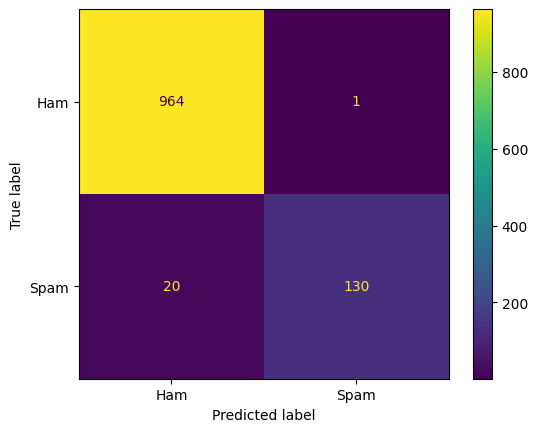

Confusion Matrix by Percentages:


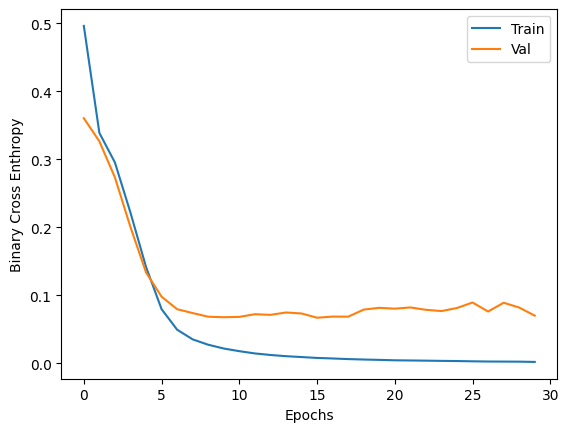

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [34]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(baseline_nn, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- This model performs good, but probably we can achieve something better.

Some observations:
- Recall is 84%, around a 25-35% jump from the ensemble models we previously tried.
- Training and validation set go hand in hand, so there is probably no overfititng.
- Validation loss (Binary Cross Entropy) descended all the way from 0.53 to 0.06, meaning it has a good performance.

#### Baseline Model Improvement
Some adjustments will be made to our model, in order to see if we can improve the 84% recall we currently have. These include:

- Adding hidden layers
- Trying different number of neurons
- Changing parameters (learning rate, dropout, etc.)

##### Experiment 1
- Add hidden layer

In [35]:
# set random seed
backend.clear_session()
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [36]:
embedding_dim = 32
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

exp1 = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 16 neurons and relu activation
    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(16, activation='relu'),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

exp1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 32)            242176    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 242993 (949.19 KB)
Trainable params: 24299

Epoch 1/30
105/105 [==============================] - 1s 3ms/step - loss: 0.5499 - accuracy: 0.8459 - val_loss: 0.3706 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8659 - val_loss: 0.3348 - val_accuracy: 0.8655
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.8659 - val_loss: 0.2448 - val_accuracy: 0.8717
Epoch 4/30
105/105 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.9402 - val_loss: 0.1146 - val_accuracy: 0.9668
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0539 - accuracy: 0.9853 - val_loss: 0.0750 - val_accuracy: 0.9731
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.0751 - val_accuracy: 0.9749
Epoch 7/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0648 - val_accuracy: 0.9794
Epoch 

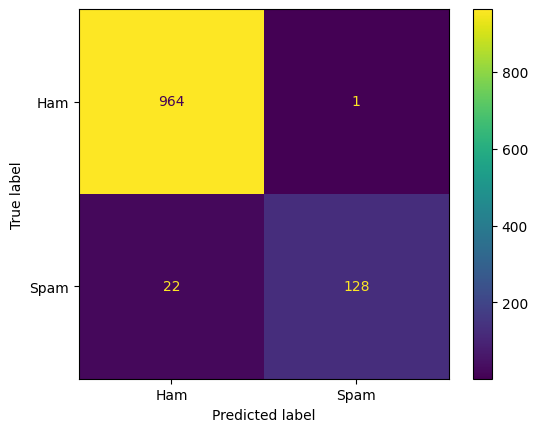

Confusion Matrix by Percentages:


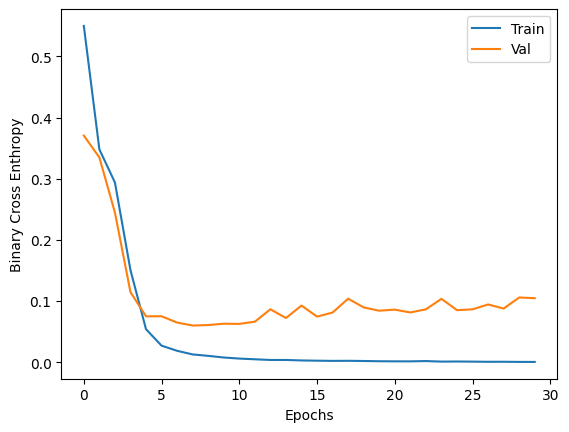

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [37]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(exp1, optimizer, loss, metric, train_batches, val_batches)

##### Insight
Observations:
- Really similar performance to previous model, recall went up by 1% and validation loss is really similar, except for the fact that it increased at the final epochs
- Through empirical inference we can conclude that increasing the number of layers is not the answer to improve our model, let's try increasing the number of neurons


##### Experiment 2
- Increase number of neurons

In [38]:
# set random seed
backend.clear_session()
np.random.seed(3)
random.seed(3)
tf.random.set_seed(3)

In [39]:
embedding_dim = 32
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

exp2 = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

exp2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 32)            242176    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 263041 (1.00 MB)
Trainable params: 263041 

Epoch 1/30
105/105 [==============================] - 1s 3ms/step - loss: 0.4327 - accuracy: 0.8594 - val_loss: 0.3393 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.8953 - val_loss: 0.1054 - val_accuracy: 0.9695
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0638 - val_accuracy: 0.9839
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0631 - val_accuracy: 0.9794
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9949 - val_loss: 0.0619 - val_accuracy: 0.9812
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0718 - val_accuracy: 0.9812
Epoch 7/30
105/105 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0769 - val_accuracy: 0.9812
Epoch 

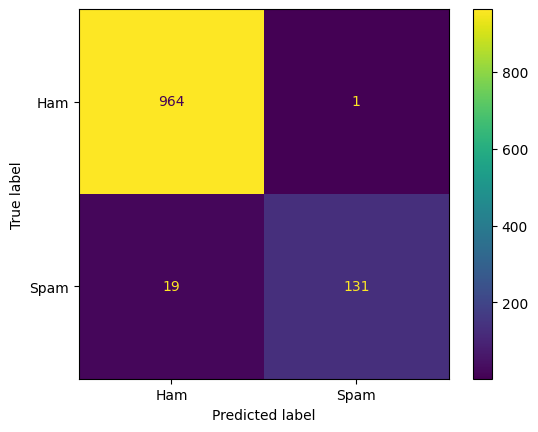

Confusion Matrix by Percentages:


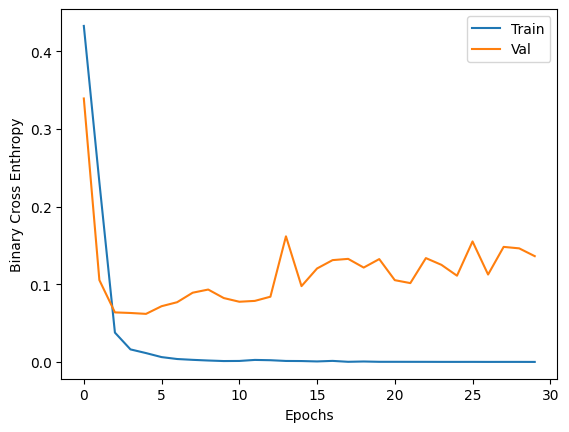

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [40]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(exp2, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- We got slightly better results, but a little more overfitting.

##### Experiment 3
- Add dropout layer

In [41]:
# set random seed
backend.clear_session()
np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)

In [42]:
embedding_dim = 32
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

exp3 = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

exp3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 32)            242176    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

Epoch 1/30
105/105 [==============================] - 1s 4ms/step - loss: 0.4155 - accuracy: 0.8656 - val_loss: 0.3437 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.2433 - accuracy: 0.8917 - val_loss: 0.1355 - val_accuracy: 0.9605
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9880 - val_loss: 0.0716 - val_accuracy: 0.9749
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.0747 - val_accuracy: 0.9749
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.0620 - val_accuracy: 0.9812
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0622 - val_accuracy: 0.9821
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.1028 - val_accuracy: 0.9758
Epoch 

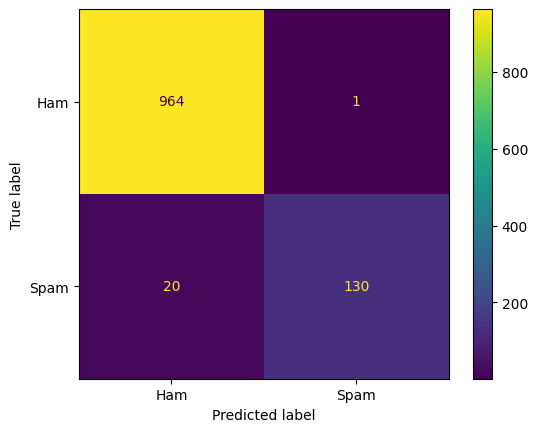

Confusion Matrix by Percentages:


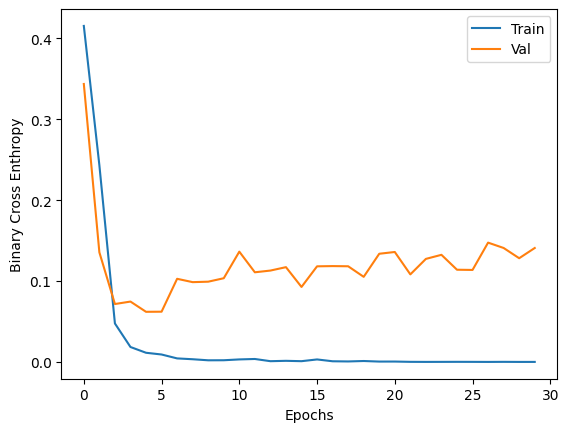

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [43]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(exp3, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- We got almost exactly the same results as Experiment 2

##### Experiment 4
Layers:
- Embedding
- Pooling
- 3 Dense
- 3 Dropout (20%)

In [44]:
# set random seed
backend.clear_session()
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

In [45]:
embedding_dim = 32
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

exp4 = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

     # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

     # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

exp4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 32)            242176    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

Epoch 1/30
105/105 [==============================] - 1s 4ms/step - loss: 0.3992 - accuracy: 0.8609 - val_loss: 0.3164 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9315 - val_loss: 0.1728 - val_accuracy: 0.9677
Epoch 3/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0760 - val_accuracy: 0.9812
Epoch 4/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.0712 - val_accuracy: 0.9785
Epoch 5/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9949 - val_loss: 0.0717 - val_accuracy: 0.9794
Epoch 6/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.1263 - val_accuracy: 0.9749
Epoch 7/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1497 - val_accuracy: 0.9749
Epoch 

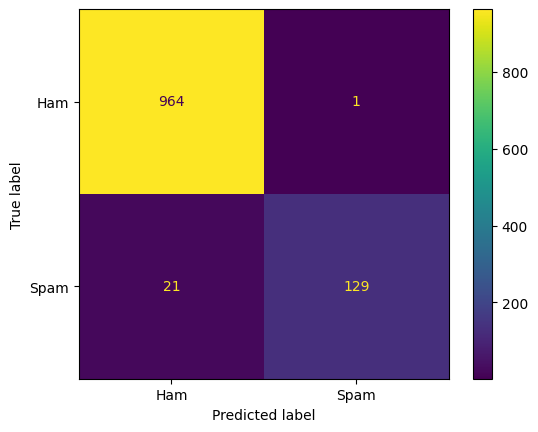

Confusion Matrix by Percentages:


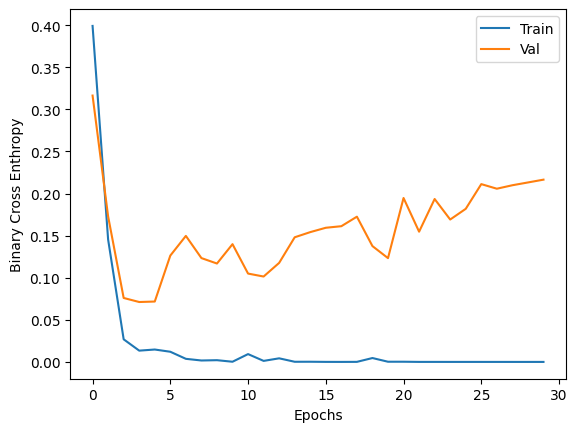

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.86      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [46]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(exp4, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- Model is highly overfitting, and performs worse than models 2 and 3.
- Adding more layers is not the answer.

##### Experiment 5
- Increase size of word_embedding

In [47]:
# set random seed
backend.clear_session()
np.random.seed(6)
random.seed(6)
tf.random.set_seed(6)

In [48]:
embedding_dim = 128
vocab_size = len(word_index)
input_shape = [train_pad.shape[1],]

exp5 = tf.keras.Sequential([
    # word embedding
     tf.keras.layers.Embedding(input_dim=vocab_size+1,
                               output_dim=embedding_dim,
                               input_shape=input_shape,
                               name="Embedding_Layer"),
                               
    # gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # dropout layer with 20% rate
    tf.keras.layers.Dropout(0.20),

    # hidden Dense layer, 128 neurons and relu activation
    tf.keras.layers.Dense(128, activation='relu'),

    # output layer, sigmoid function
    tf.keras.layers.Dense(1, activation="sigmoid")
])

exp5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding  (None, 64, 128)           968704    
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 1

Epoch 1/30
105/105 [==============================] - 1s 7ms/step - loss: 0.3913 - accuracy: 0.8624 - val_loss: 0.3009 - val_accuracy: 0.8655
Epoch 2/30
105/105 [==============================] - 1s 6ms/step - loss: 0.1405 - accuracy: 0.9393 - val_loss: 0.1232 - val_accuracy: 0.9686
Epoch 3/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0307 - accuracy: 0.9895 - val_loss: 0.0680 - val_accuracy: 0.9794
Epoch 4/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.0732 - val_accuracy: 0.9794
Epoch 5/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.1057 - val_accuracy: 0.9776
Epoch 6/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.1179 - val_accuracy: 0.9767
Epoch 7/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.1067 - val_accuracy: 0.9794
Epoch 

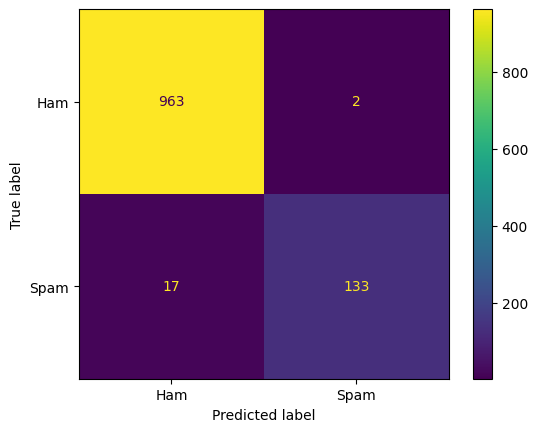

Confusion Matrix by Percentages:


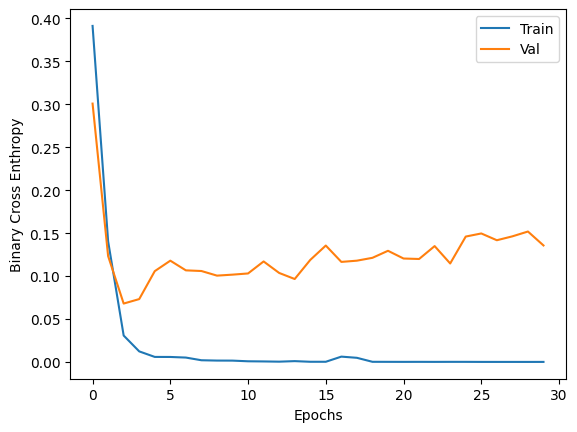

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [49]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

train_nn(exp5, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- We got the highest recall in all our models.
- Even though it does not have the lowest validation accuracy this may be the best model of all.

##### Experiment 6
- Increase training data, using _exp5_ model
- Necessary to repeat preprocessing steps:
    - Train-Test Split (80-10-10)
    - Padding
    - TF Datasets

In [50]:
# define x and y
x = encoded_data
y = df["label"]

# define x and y
x = encoded_data
y = df["label"]

# train 90 - test 10
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

# train 80 - val 10
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111, stratify=y_train, random_state=42)

# in other words, 88.89% of 90 (80) to train
# and 11.11% of 90 (10) to val

print(len(x_train), len(x_test), len(x_val))

4456 558 558


In [51]:
# use maxlen to make all sequences of same size
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

train_pad = pad_sequences(x_train, padding="post", maxlen=64)
val_pad = pad_sequences(x_val, padding="post", maxlen=64)
test_pad = pad_sequences(x_test, padding="post", maxlen=64)

# shapes
# (observations, length of array)
print(train_pad.shape)
print(val_pad.shape)
print(test_pad.shape)
print()

# take one sample from each set
print(train_pad[0])
print(val_pad[0])
print(test_pad[0])

(4456, 64)
(558, 64)
(558, 64)

[  63  227   39 6267   39    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[5701  303    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[   3  107   58 1158   12  987 1158    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  

In [52]:
# create tensorflow datasets
# tensor_slices = tf.data.Dataset.from_tensor_slices
tensors = tf.data.Dataset.from_tensor_slices

train_slice = tensors((train_pad, y_train))
val_slice = tensors((val_pad, y_val))
test_slice = tensors((test_pad, y_test))

In [53]:
train_batches = train_slice.shuffle(len(train_slice), seed=42).batch(32)
val_batches = val_slice.shuffle(len(val_slice), seed=42).batch(32)
test_batches = test_slice.shuffle(len(test_slice)).batch(12)

Epoch 1/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0355 - accuracy: 0.9939 - val_loss: 0.0433 - val_accuracy: 0.9946
Epoch 2/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0184 - accuracy: 0.9962 - val_loss: 0.0388 - val_accuracy: 0.9910
Epoch 3/30
140/140 [==============================] - 1s 7ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 0.0440 - val_accuracy: 0.9892
Epoch 4/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.0399 - val_accuracy: 0.9910
Epoch 5/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0433 - val_accuracy: 0.9928
Epoch 6/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 7/30
140/140 [==============================] - 1s 6ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0511 - val_accuracy: 0.9910
Epoch 

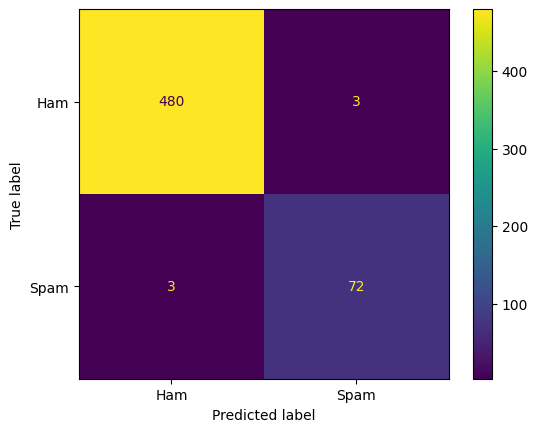

Confusion Matrix by Percentages:


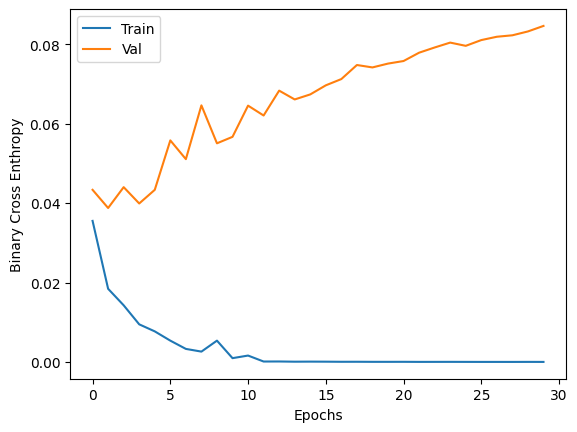

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       483
           1       0.96      0.96      0.96        75

    accuracy                           0.99       558
   macro avg       0.98      0.98      0.98       558
weighted avg       0.99      0.99      0.99       558



In [54]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

exp6 = exp5
train_nn(exp6, optimizer, loss, metric, train_batches, val_batches)

##### Insight 
- Model has great performance, with lowest loss and highest recall
- More training data does increase model performance
    - Exp5: Loss=.1036, Recall=89%
    - Ex-6L Loss=.0636, Recall=96%
- Model is highly overfitting. _exp1_ is the one that overfits the least, so we will test the increased data approach on model 1.


##### Experiment 7
- Increased data on baseline model

Epoch 1/30
140/140 [==============================] - 1s 3ms/step - loss: 0.0230 - accuracy: 0.9939 - val_loss: 0.0278 - val_accuracy: 0.9946
Epoch 2/30
140/140 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9951 - val_loss: 0.0303 - val_accuracy: 0.9928
Epoch 3/30
140/140 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9962 - val_loss: 0.0294 - val_accuracy: 0.9946
Epoch 4/30
140/140 [==============================] - 0s 1ms/step - loss: 0.0170 - accuracy: 0.9966 - val_loss: 0.0296 - val_accuracy: 0.9946
Epoch 5/30
140/140 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9962 - val_loss: 0.0299 - val_accuracy: 0.9946
Epoch 6/30
140/140 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9973 - val_loss: 0.0304 - val_accuracy: 0.9964
Epoch 7/30
140/140 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.0306 - val_accuracy: 0.9964
Epoch 

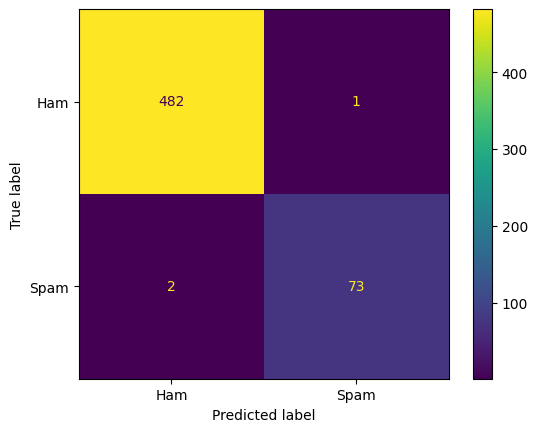

Confusion Matrix by Percentages:


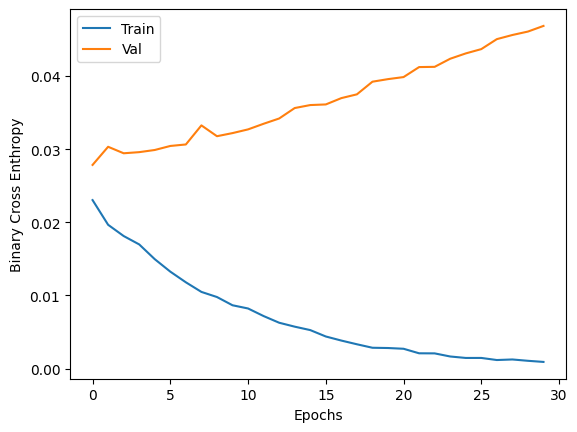

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       0.99      0.97      0.98        75

    accuracy                           0.99       558
   macro avg       0.99      0.99      0.99       558
weighted avg       0.99      0.99      0.99       558



In [55]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

exp7 = baseline_nn

train_nn(exp7, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- Great results, as recall is the same as Experiment 6 and loss decreased by almost 2%
- We can see that as epochs increases so does loss, so we will try Early Stopping

##### Experiment 8
- Early Stopping
    - Change function to stop on 10 epochs

In [56]:
def train_nn(model,
             optimizer,
             loss,
             metric,
             train_data,
             val_data):
    """
    User defined function to train a neural network and show: 1 confusion matrix, 2 loss graph, 3 classification report.
    It is necessary to specify beforehand: 1 optimizer, 2 loss, 3 metric, as well as building the model itself
    before using the function.
    """

    # compile model
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metric)

    # fit model
    history = model.fit(train_batches,
                        epochs=10,
                        validation_data=val_batches)
    
    # predict on validation data
    preds = model.predict(val_pad)

    # if model predicts greater than .50, make it 1, otherwise 0
    # set threshold at 50%
    pred_labels = np.where(preds > 0.5, 1, 0)

    cm = confusion_matrix(y_val, pred_labels)
    labels = ['Ham', 'Spam']
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.show()

    print("Confusion Matrix by Percentages:")
    cm_perc = ((confusion_matrix(y_val, pred_labels) / len(val_pad))*100).round(2)
    cm_perc

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.ylabel("Binary Cross Enthropy")
    plt.xlabel("Epochs")
    plt.show()

    print(classification_report(y_val, pred_labels))

Epoch 1/10
140/140 [==============================] - 1s 2ms/step - loss: 8.7590e-04 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9946
Epoch 2/10
140/140 [==============================] - 0s 2ms/step - loss: 7.5497e-04 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9946
Epoch 3/10
140/140 [==============================] - 0s 2ms/step - loss: 5.3617e-04 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9946
Epoch 4/10
140/140 [==============================] - 0s 2ms/step - loss: 5.4145e-04 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9910
Epoch 5/10
140/140 [==============================] - 0s 2ms/step - loss: 4.0995e-04 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 0.9946
Epoch 6/10
140/140 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0546 - val_accuracy: 0.9946
Epoch 7/10
140/140 [==============================] - 0s 2ms/step - loss: 2.8324e-04 - accuracy: 1.0000 - val_loss: 0.0559 - val

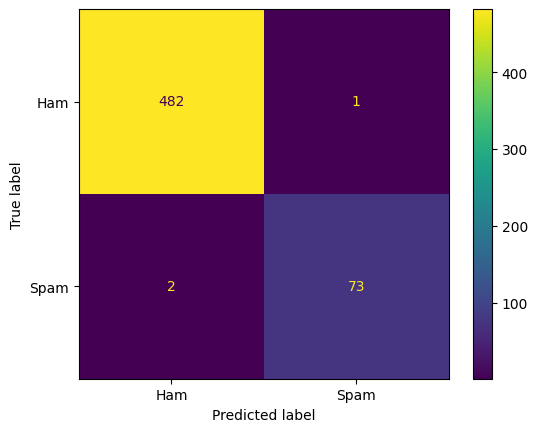

Confusion Matrix by Percentages:


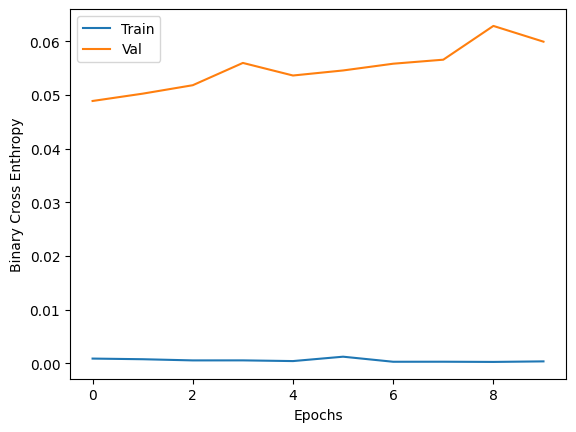

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       0.99      0.97      0.98        75

    accuracy                           0.99       558
   macro avg       0.99      0.99      0.99       558
weighted avg       0.99      0.99      0.99       558



In [57]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = ["accuracy"]

exp8 = baseline_nn

train_nn(exp8, optimizer, loss, metric, train_batches, val_batches)

##### Insight
- Early Stopping did not have a significant effect on our model, in fact it is slightly worse, so it is better to stick with the previous model

### Model Comparisons

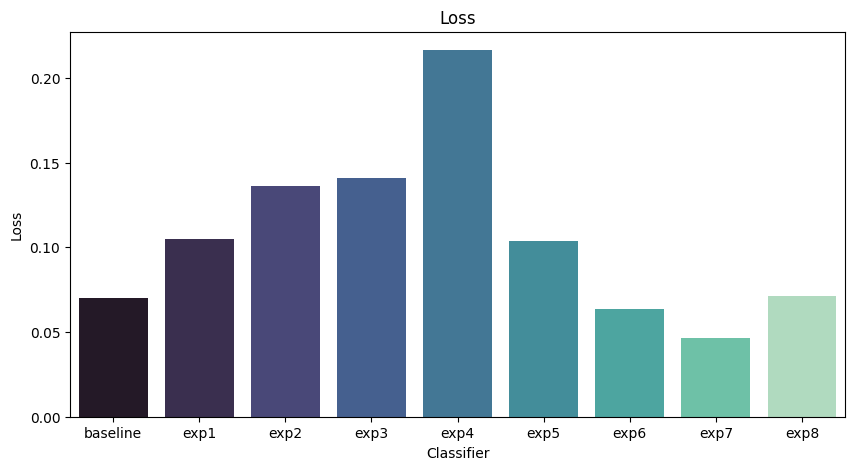

In [58]:
experiments = ["baseline", "exp1", "exp2", "exp3", "exp4", "exp5", "exp6", "exp7", "exp8"]
loss = [.0700, .1047, .1362, .1409, .2165, .1036, .0638, .0463, .0710]

plt.figure(figsize=(10,5))
sns.barplot(x=experiments, y=loss,
            palette="mako")
plt.title("Loss")
plt.xlabel("Classifier")
plt.ylabel("Loss")
plt.show()

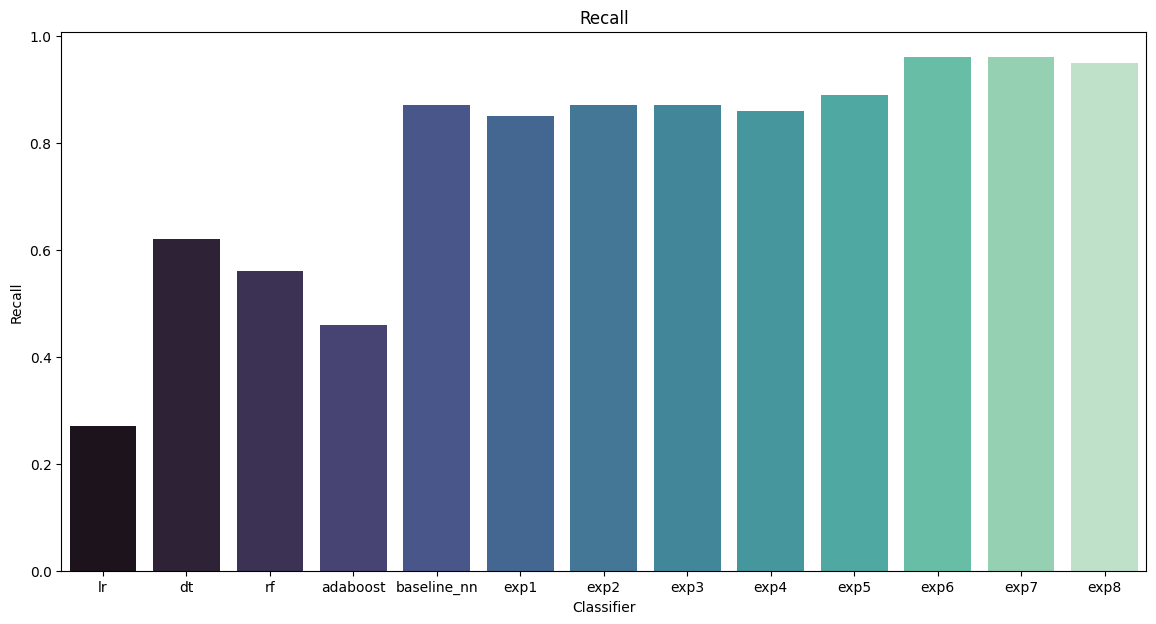

In [59]:
experiments = ["lr", "dt", "rf", "adaboost", "baseline_nn", "exp1", "exp2", "exp3", "exp4", "exp5", "exp6", "exp7", "exp8"]
recall = [.27, .62, .56, .46, .87, .85, .87, .87, .86, .89, .96, .96, .95]

plt.figure(figsize=(14,7))
sns.barplot(x=experiments, y=recall,
            palette="mako")
plt.title("Recall")
plt.xlabel("Classifier")
plt.ylabel("Recall")
plt.show()

#### Best Model
- By all means, our best model is Experiment 7. 
- Experiment 7 is our baseline deep learning model for this project, it is virtually equal to Experiment 1 but with increased training data, which in consequence descreases loss and increases recall.
- Architecture:
    - Embedding Layer
    - Global Average Pooling
    - Dense Layer with 16 neurons
    - Dense Layer with 1 neuron (output layer)

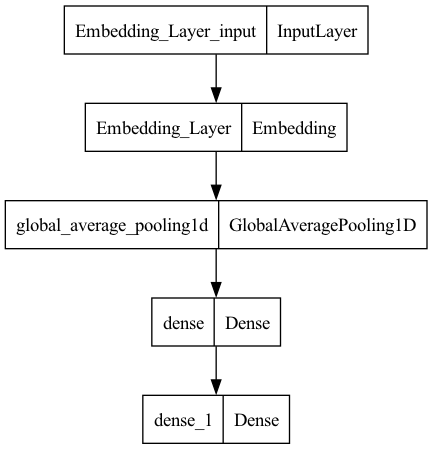

In [60]:
plot_model(exp7)

##### Save Model

In [61]:
import joblib
joblib.dump(exp7, "att_deeplearning_model")

['att_deeplearning_model']

## Conclusions
- More training data leads to better results.
- "Simplicity is the ultimate sophistication".
- Our model cannot be complex because our training data is not big enough.
- Deep Learning has an extremely better performance than ensemble models. 
- For future model improvement it is recommended to increase data, it can be done by having more real samples or through data augmentation techniques.

##### 